# Real or Not? NLP with Disaster Tweets

Predict which Tweets are about real disasters and which ones are not

In [1]:
# !kaggle competitions list
# !kaggle competitions download -c nlp-getting-started 

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import mglearn

import re
import string

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

## Load data

In [50]:
# Load training and testing datasets to DataFrame
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print('Full training data size:', df_train.shape)
print('Testing data size:', df_test.shape)

Full training data size: (7613, 5)
Testing data size: (3263, 4)


In [55]:
# Check the training data
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [56]:
# Check the testing data
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## EDA

### Class distrubution

In [3]:
def plot_class_layout(df, col):
    """Plot the distribution of classes.  
       df: a pandas DataFrame,
       col: name of column indicating class labels."""
    x = df[col].value_counts()
    plt.figure()
    sns.barplot(x.index, x)
    plt.gca().set_ylabel('Samples')
    plt.show()

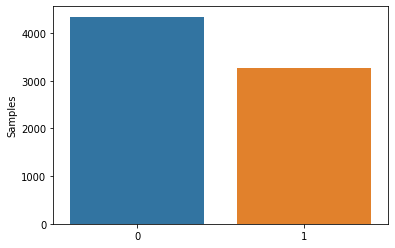

Samples per class (traninig): [4342 3271]


In [5]:
plot_class_layout(df_train, 'target')
print('Samples per class (traninig): {}'.format(np.bincount(df_train['target'])))

### Number of characters

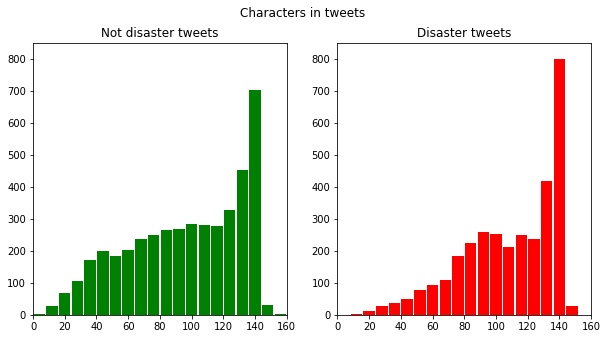

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

tweet_len = df_train[df_train['target']==0]['text'].str.len()
ax1.hist(tweet_len, bins=20, range=(0, 160), color='g', rwidth=0.9)
ax1.set_title('Not disaster tweets')
ax1.set_xlim(0, 160)
ax1.set_ylim(0, 850)

tweet_len = df_train[df_train['target']==1]['text'].str.len()
ax2.hist(tweet_len, bins=20, range=(0, 160), color='r', rwidth=0.9)
ax2.set_title('Disaster tweets')
ax2.set_xlim(0, 160)
ax2.set_ylim(0, 850)

fig.suptitle('Characters in tweets')
plt.show()

### Number of words

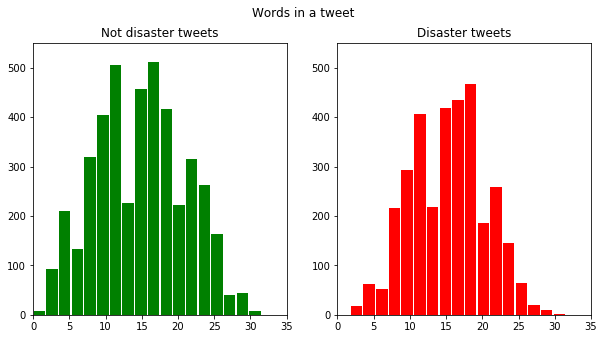

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

tweet_len = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len, bins=20, range=(0, 35), color='g', rwidth=0.9)
ax1.set_title('Not disaster tweets')
ax1.set_xlim(0, 35)
ax1.set_ylim(0, 550)

tweet_len = df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, bins=20, range=(0, 35), color='r', rwidth=0.9)
ax2.set_title('Disaster tweets')
ax2.set_xlim(0, 35)
ax2.set_ylim(0, 550)

fig.suptitle('Words in a tweet')
plt.show()

### Average word length in a tweet

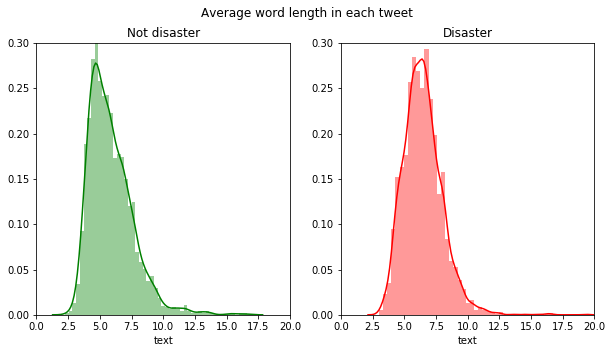

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

word = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='g')
ax1.set_title('Not disaster')
ax1.set_xlim(0, 20)
ax1.set_ylim(0, .3)

word = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='r')
ax2.set_title('Disaster')
ax2.set_xlim(0, 20)
ax2.set_ylim(0, .3)

fig.suptitle('Average word length in each tweet')
plt.show()

## Text preprocessing

### Words/characters cleaning

#### Remove URL

In [57]:
def remove_url(text):
    """Remove URL in the text."""
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [58]:
df_train['text'] = df_train['text'].apply(remove_url)
df_test['text'] = df_test['text'].apply(remove_url)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Removing HTML tags

In [59]:
def remove_html(text):
    """Remove HTML tags in the text."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

In [60]:
df_train['text'] = df_train['text'].apply(remove_html)
df_test['text'] = df_test['text'].apply(remove_html)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Romove emojis

In [61]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [62]:
df_train['text'] = df_train['text'].apply(remove_emoji)
df_test['text'] = df_test['text'].apply(remove_emoji)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Remove punctuations

In [63]:
def remove_punctuation(text):
    """Remove punctuations in text."""
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    table = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(table)

In [64]:
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_test['text'] = df_test['text'].apply(remove_punctuation)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


#### Spelling correction (normalization)

In [ ]:
from spellchecker import SpellChecker

def correct_spelling(text):
    """Correct spelling mistakes in the text."""
    corrected_text = []
    spell = SpellChecker()
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [17]:
#df_train['text'] = df_train['text'].apply(correct_spelling)
#df_test['text'] = df_test['text'].apply(correct_spelling)

#### Stemming (normalization)

In [65]:
from nltk.stem.snowball import SnowballStemmer

SBStemmer = SnowballStemmer('english')

def stem_word(text):    
    """Stem each word based on word root in the given text."""
    text = [SBStemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [66]:
df_train['text'] = df_train['text'].apply(stem_word)
df_test['text'] = df_test['text'].apply(stem_word)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deed are the reason of this earthquak may ...,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,all resid ask to shelter in place are be notif...,1
3,6,NaN,NaN,13000 peopl receiv wildfir evacu order in cali...,1
4,7,NaN,NaN,just got sent this photo from rubi alaska as s...,1


#### Lemmatization (normalization)

In [6]:
import spacy # !python -m spacy download en_core_web_sm
import nltk

# load spacy's English language models
en_nlp = spacy.load('en_core_web_sm')
# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

In [28]:
# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print('Lemmatization:')
    print([token.lemma_ for token in doc_spacy if token.lemma_ != '-PRON-'])
    # print tokens found by Porter stemmer
    print('Stemming')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [30]:
compare_normalization("Our meeting today was worse than yesterday, "
                       "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


#### Remove stopwords

In [67]:
from nltk.corpus import stopwords

sw = stopwords.words('english')

# display the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [68]:
def remove_stopwords(text):
    """Remove stopwards in text."""
    # remove the stop words and lowercase the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [69]:
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deed reason earthquak may allah forgiv us,1
1,4,NaN,NaN,forest fire near la rong sask canada,1
2,5,NaN,NaN,resid ask shelter place notifi offic evacu she...,1
3,6,NaN,NaN,13000 peopl receiv wildfir evacu order california,1
4,7,NaN,NaN,got sent photo rubi alaska smoke wildfir pour ...,1


### Text vectorization

#### Bag-of-words

- Tokenization
- Vocabulary building
- Encoding (one-hot)
- n-Grams

In [51]:
X_full_text = df_train['text']
y_full = df_train['target']

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_full_text, y_full, test_size=0.2, random_state=0)

print('X_train_text size: ', X_train_text.shape)
print('X_val_text size: ', X_val_text.shape) 

X_train_text size:  (6090,)
X_val_text size:  (1523,)


In [71]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1, 1), min_df=5)
vect.fit(X_train_text)
X_train = vect.transform(X_train_text)
print('X_train:\n{}'.format(repr(X_train)))

X:
<6090x2057 sparse matrix of type '<class 'numpy.int64'>'
	with 40430 stored elements in Compressed Sparse Row format>


In [73]:
feature_names = vect.get_feature_names()
print('Number of features: {}'.format(len(feature_names)))
print('First 100 features:\n{}'.format(feature_names[:100]))
print('Every 100 features:\n{}'.format(feature_names[::100]))

Number of features: 2057
First 100 features:
['05', '06', '10', '100', '1000', '11', '11yearold', '12', '12000', '13', '14', '15', '16', '16yr', '17', '18', '19', '1980', '1st', '20', '2011', '2013', '2014', '2015', '21', '22', '24', '25', '26', '2nd', '30', '31', '320', '33', '3g', '40', '4000', '4wd', '4x4', '50', '500', '5km', '60', '600', '70', '70th', '731', '90', '911', '97georgia', 'aba', 'abandon', 'abc', 'abl', 'ablaz', 'abov', 'absolut', 'abstorm', 'abus', 'accid', 'accord', 'account', 'accus', 'acr', 'across', 'act', 'action', 'activ', 'actual', 'ad', 'add', 'address', 'admit', 'adult', 'advanc', 'advisori', 'af', 'affect', 'afghan', 'afghanistan', 'afraid', 'africa', 'afternoon', 'aftershock', 'age', 'ago', 'agre', 'ah', 'ahead', 'aid', 'aim', 'aint', 'air', 'aircraft', 'airlin', 'airplan', 'airport', 'aka', 'alabama', 'alarm']
Every 100 features:
['05', 'alaska', 'ban', 'brother', 'co', 'dc', 'econom', 'favorit', 'glass', 'hous', 'killer', 'magic', 'mountain', 'pakistani',

#### Vectorization for GloVe

In [18]:
from nltk.tokenize import word_tokenize

def create_corpus(df):
    """Create corpus of the texts."""
    corpus = []
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==1) & (word not in sw))]
        corpus.append(words)
    return corpus

In [19]:
# Create corpus
corpus = create_corpus(df_train)

100%|██████████| 7613/7613 [00:04<00:00, 1551.02it/s]


In [20]:
embedding_dict = {}
with open('/home/ys/data/nlp-getting-started/glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
f.close()

In [21]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [22]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 13077


In [23]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 13077/13077 [00:00<00:00, 92236.37it/s] 


## Build the model

### Logistic regression

In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=500)
scores = cross_val_score(lr, X_train, y_train, scoring='f1')
print('Mean cross-validation f1 score: {:.2f}'.format(np.mean(scores)))

Mean cross-validation f1 score: 0.74


In [96]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(lr, param_grid, scoring='f1')
grid.fit(X_train, y_train)
print('Best cross-validation f1 score: {:.2f}'.format(grid.best_score_))
print('Best parameters: ', grid.best_params_)
print('Best estimator: ', grid.best_estimator_)

Best cross-validation f1 score: 0.74
Best parameters:  {'C': 1}
Best estimator:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [87]:
from sklearn.metrics import f1_score

X_val = vect.transform(X_val_text)
y_val_pred = grid.best_estimator_.predict(X_val)
f1score = f1_score(y_val, y_val_pred)
print(f'Model (Logistic Regression) F1 Score: {f1score * 100:.2f}%')

Model (Logistic Regression) F1 Score: 73.55%


In [88]:
# A better way
print('F1 score of validation data: {:.2f}'.format(grid.score(X_val, y_val)))

F1 score of validation data: 0.74


In [89]:
from sklearn.metrics import confusion_matrix
print('Confusion matrix:\n', confusion_matrix(y_val, y_val_pred))

Confusion matrix:
 [[770 116]
 [199 438]]


In [90]:
# Retrain full (train + val) data with the optimal model
lr_best = LogisticRegression(C=1, max_iter=500)
X_full = vect.transform(X_full_text)
lr_best.fit(X_full, y_full)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
# Predict test tweets
X_test = vect.transform(df_test['text'])
y_test_pred = lr_best.predict(X_test)

In [94]:
# Save submissin file
df_sub = pd.read_csv('sample_submission.csv')
df_sub['target'] = y_test_pred
df_sub.to_csv('submission.csv', index=False)
df_sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


#### tf-idf scaling

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), 
                     LogisticRegression(max_iter=500))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, scoring='f1')
grid.fit(X_train_text, y_train)
print('Best cross-validation f1-score: {:.2f}'.format(grid.best_score_))

Best cross-validation f1-score: 0.74


In [125]:
tvect = grid.best_estimator_.named_steps['tfidfvectorizer']

# transform the training datsets
X_train = tvect.transform(X_train_text)
# find maximm value for each of the features over the datasets
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(tvect.get_feature_names())

print('Features with lowest tfidf:\n{}'.format(
    feature_names[sorted_by_tfidf[:20]]))
print('Features with highest tfidf:\n{}'.format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['fatal' 'come' 'death' 'scream' 'hijack' 'weapon' 'full' 'deton' 'right'
 'last' 'mani' 'wave' 'die' 'catastroph' 'explod' 'hot' 'photo' 'demolish'
 'fall' 'casualti']
Features with highest tfidf:
['test' 'beach' 'omg' 'pray' 'bag' 'pain' 'lane' 'awesom' 'navi' 'fuck'
 'nc' 'ar' 'hill' 'gtgt' 'issu' 'shoe' 'fire' 'check' 'hey' 'bestnaijamad']


In [130]:
sorted_by_idf = np.argsort(tvect.idf_)
print('Features with lowest idf (less important):\n{}'.format(
    feature_names[sorted_by_idf[:100]]))

Features with lowest idf (less important):
['like' 'fire' 'get' 'im' 'amp' 'bomb' 'new' 'via' 'one' 'go' 'peopl'
 'news' 'dont' 'burn' 'emerg' 'kill' 'video' 'us' 'flood' 'bodi' 'crash'
 'time' 'year' 'attack' 'build' 'look' 'say' 'fatal' 'disast' 'still'
 'evacu' 'would' 'day' 'california' 'home' 'ûª' 'polic' 'come' 'train'
 'see' 'make' 'know' 'back' 'storm' 'love' 'famili' 'death' 'watch'
 'collaps' 'world' 'live' 'first' 'dead' 'derail' 'got' 'scream' 'whi'
 'today' 'suicid' 'cant' 'bag' 'rt' 'take' 'hijack' 'war' 'drown' 'think'
 'want' 'work' 'man' 'car' 'need' 'youtub' 'caus' 'murder' 'plan'
 'nuclear' 'let' 'full' 'weapon' 'destroy' 'help' 'obliter' 'may' 'accid'
 'deton' 'hiroshima' 'report' 'two' 'good' 'feel' 'wreck' 'fear' 'life'
 'onli' 'right' 'best' 'wildfir' 'servic' 'way']


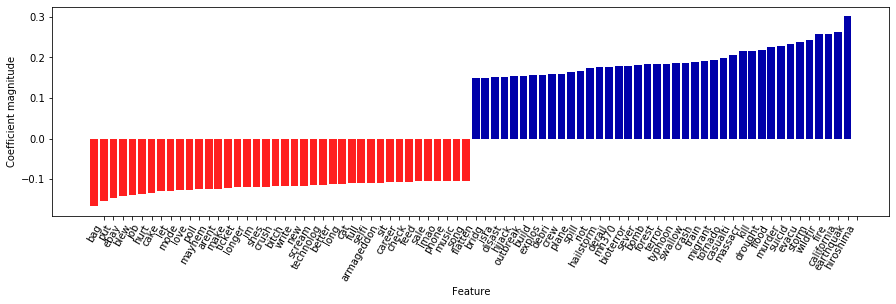

In [132]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_, 
    feature_names, n_top_features=40)

#### n-Grams (bigrams, trigrams)

In [135]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), 
                     LogisticRegression(max_iter=500))
# ruuning takes a long time
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, scoring='f1')
grid.fit(X_train_text, y_train)
print('Best cross-validation f1-score: {:.2f}'.format(grid.best_score_))
print('Best parameters:\n{}'.format(grid.best_params_))

Best cross-validation f1-score: 0.74
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}


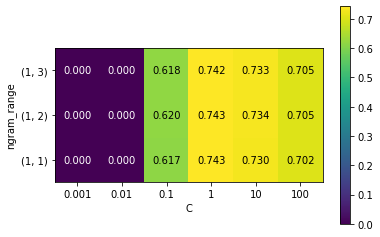

In [148]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel='C', ylabel='ngram_range', cmap='viridis', fmt='%.3f', 
    xticklabels=param_grid['logisticregression__C'], 
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

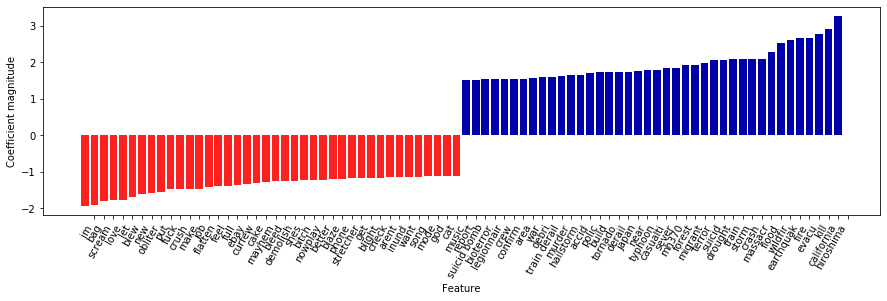

In [194]:
# extract features names and coefficients
tvect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(tvect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
bottom, top = plt.ylim()

(-2.1930937514043407, 3.526960240914482)

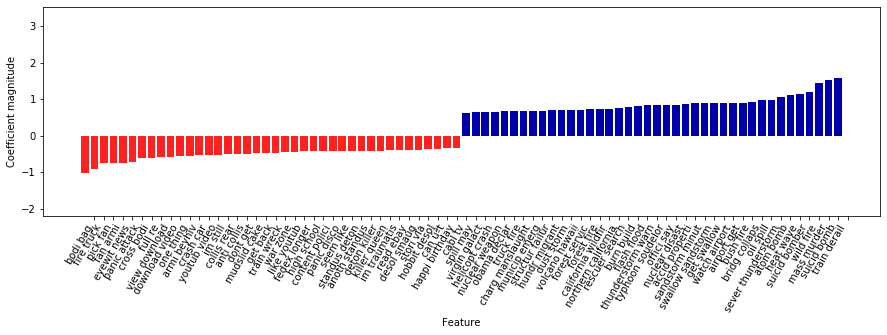

In [195]:
# find 2-gram feaures
mask = np.array([len(feature.split(' ')) for feature in feature_names]) == 2
# visualize only 2-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask], 
                                     feature_names[mask], n_top_features=40)
plt.ylim(bottom, top)

#### CountVectorizer wth lemmatization

In [57]:
# regexp used in CountVectorizer
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old (default) tokenizer
nlp = spacy.load('en_core_web_sm')
old_tokenizer = nlp.tokenizer
# replace the tokenizer with the preceding regexp
# nlp <-- old_tokenizer.tokens_from_list (new in v2.0)
nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# create a custom tokenizer using the spacy document processing pipeline
# (now using our own tokennizer)
def custom_tokenizer(document):
    doc_spacy = nlp(document, disable=["tagger", "parser"])
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [59]:
# transform X_train_text using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(X_train_text)
print('X_train_lemma.shape: {}'.format(X_train_lemma.shape))

### Dense NN layers

In [27]:
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
network = Sequential()

network.add(Dense(32, kernal_regularizer=regularizers.l2(0.001), 
                  activation='relu', input_shape=(14722,)))
network.add(Dropout(0,5))
network.add(Dense(32, kernal_regularizer=regularizers.l2(0.001), 
                  activation='relu'))
network.add(Dropout(0,5))
network.add(Dense(1, activation='sigmoid'))

network.compile(optimizer='rmsprop', 
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = network.fit(X_train, y_train,
            batch_size=128, 
            epochs=10, 
            validation_data=(X_val, y_val))

Train on 6090 samples, validate on 1523 samples
Epoch 1/3
6090/6090 [==============================] - 9s 1ms/sample - loss: 0.6381 - accuracy: 0.7197 - val_loss: 0.5678 - val_accuracy: 0.7932
Epoch 2/3
6090/6090 [==============================] - 4s 683us/sample - loss: 0.4792 - accuracy: 0.8407 - val_loss: 0.4694 - val_accuracy: 0.7945
Epoch 3/3
6090/6090 [==============================] - 4s 687us/sample - loss: 0.3616 - accuracy: 0.8727 - val_loss: 0.4347 - val_accuracy: 0.8050


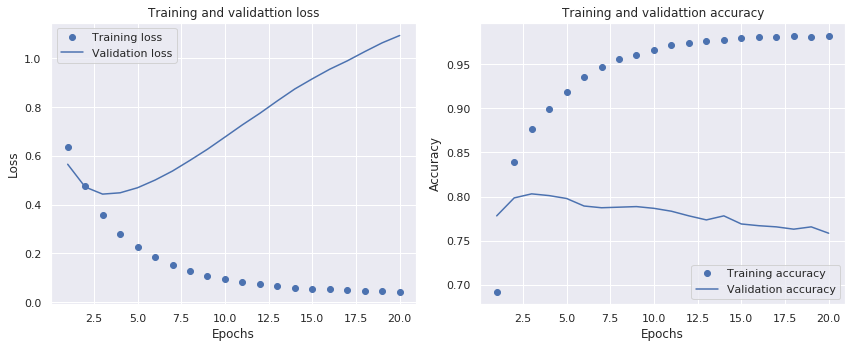

In [23]:
history_dict = history.history
loss_values = history_dict['loss']
acc_values = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b-', label='Validation loss')
plt.title('Training and validattion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b-', label='Validation accuracy')
plt.title('Training and validattion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
X_test = vectorizer.transform(df_test['text']).toarray()
y_pred = network.predict(X_test)

df_sub = pd.read_csv('sample_submission.csv')
df_sub['target'] = np.round(y_pred.squeeze()).astype(int)
df_sub.to_csv('submission.csv', index=False)
df_sub.head()

### GloVe

In [24]:
model = Sequential()

embedding = Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix),
                      input_length=MAX_LEN, trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

optimzer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy'])

In [26]:
train = tweet_pad[:df_train.shape[0]]
test = tweet_pad[df_train.shape[0]:]

In [27]:
X_train, X_test, y_train, y_test = \
    train_test_split(train, df_train['target'].values, test_size=0.15)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [28]:
history = model.fit(X_train, y_train, batch_size=4, epochs=10, 
                    validation_data=(X_test,y_test), verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/10
6471/6471 - 126s - loss: 0.6916 - accuracy: 0.5668 - val_loss: 0.6884 - val_accuracy: 0.5893
Epoch 2/10
6471/6471 - 121s - loss: 0.6821 - accuracy: 0.5684 - val_loss: 0.6530 - val_accuracy: 0.5902
Epoch 3/10
6471/6471 - 136s - loss: 0.6344 - accuracy: 0.6419 - val_loss: 0.5749 - val_accuracy: 0.7574
Epoch 4/10
6471/6471 - 128s - loss: 0.6111 - accuracy: 0.7017 - val_loss: 0.5448 - val_accuracy: 0.7513
Epoch 5/10
6471/6471 - 128s - loss: 0.5941 - accuracy: 0.7110 - val_loss: 0.5330 - val_accuracy: 0.7574
Epoch 6/10
6471/6471 - 130s - loss: 0.5880 - accuracy: 0.7186 - val_loss: 0.5302 - val_accuracy: 0.7609
Epoch 7/10
6471/6471 - 162s - loss: 0.5840 - accuracy: 0.7181 - val_loss: 0.5243 - val_accuracy: 0.7609
Epoch 8/10
6471/6471 - 116s - loss: 0.5738 - accuracy: 0.7305 - val_loss: 0.5203 - val_accuracy: 0.7636
Epoch 9/10
6471/6471 - 114s - loss: 0.5792 - accuracy: 0.7234 - val_loss: 0.5197 - val_accuracy: 0.7618
Epoch 10/10
6471

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')
y_pred = model.predict(test)
y_pred = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pred})
sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
# !kaggle competitions submit -c nlp-getting-started -f submission.csv -m 'message'
# !kaggle competitions submissions -c nlp-getting-started